In [ ]:
import utils_io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
path_train_data = "data_set/train.csv"

origin_data = utils_io.load_csv_data(path_train_data)
# Debugging: Check the type of train_data

# Print the loaded data
if isinstance(origin_data, pd.DataFrame):
    print(f"dimension train data: {origin_data.shape}")
else:
    print("train_data is not a DataFrame")

create target data


In [ ]:
# Get target data
target_data = origin_data["SalePrice"]
print(target_data.shape)


# Drop the Id and sales price column
train_data = origin_data.drop(columns=["Id"])
print(train_data.shape)

Clean NA


In [ ]:
def auto_clean_columns(df: pd.DataFrame) -> pd.DataFrame:
    df_cleaned = df.copy()

    for column in df_cleaned.columns:
        values = df_cleaned[column].dropna().unique()

        can_be_numeric = True
        for v in values:
            if isinstance(v, str) and v.strip().upper() == "NA":
                continue
            try:
                float(v)
            except:
                can_be_numeric = False
                break

        if can_be_numeric:
            # Převést "NA" na np.nan a sloupec na float
            df_cleaned[column] = df_cleaned[column].replace("NA", np.nan)
            df_cleaned[column] = pd.to_numeric(df_cleaned[column], errors="coerce")
        else:
            # ponecháme jako kategorii se stringy
            df_cleaned[column] = df_cleaned[column].astype(str).str.strip().str.upper()

    return df_cleaned


train_data = auto_clean_columns(train_data)
# print(train_data)

Convert dataset with OneHotEncoder


In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pandas as pd


def prepare_features(df: pd.DataFrame, target_column: str):
    """
    X_train = vstupní featury (normalizované, zakódované, připravené)
    y_train = cílová hodnota (ve tvém případě MSSubClass)
    transformer = pipeline pro použití na testovacích datech
    """
    df = df.copy()

    # 1. Rozdělení cílové proměnné a vstupů
    y = df[target_column]
    X = df.drop(columns=[target_column])

    # 2. Rozdělení sloupců
    numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
    categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

    # 3. Tvorba transformací
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numerical_cols),
            (
                "cat",
                OneHotEncoder(handle_unknown="ignore", sparse_output=False),
                categorical_cols,
            ),
        ]
    )

    # 4. Pipeline (můžeš použít i s modely jako XGBoost, NN atd.)
    pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

    # 5. Fit + transform vstupní data
    X_transformed = pipeline.fit_transform(X)

    # 6. Získání názvů nových sloupců (volitelné)
    new_columns = []

    if numerical_cols:
        new_columns += numerical_cols

    if categorical_cols:
        encoder = pipeline.named_steps["preprocessor"].named_transformers_["cat"]
        new_columns += encoder.get_feature_names_out(categorical_cols).tolist()

    X_transformed_df = pd.DataFrame(X_transformed, columns=new_columns, index=X.index)

    return X_transformed_df, y, pipeline  # X, y, transformer pro testovací data

- X_train = vstupní featury (normalizované, zakódované, připravené)
- y_train = cílová hodnota (ve tvém případě MSSubClass)
- transformer = pipeline pro použití na testovacích datech


In [ ]:
x_train, y_train, transformer = prepare_features(train_data, "SalePrice")
# print(transformer)

split to train and test data


Prepare test data with transformer


In [ ]:
path_test_data = "data_set/test.csv"

test_data = utils_io.load_csv_data(path_test_data)
# Debugging: Check the type of test_data

# Print the loaded data
if isinstance(test_data, pd.DataFrame):
    print(f"dimension train data: {test_data.shape}")
else:
    print("test_data is not a DataFrame")

In [ ]:
test_data = test_data.drop(columns=["Id"])
test_data = auto_clean_columns(test_data)

In [ ]:
x_target = transformer.transform(test_data)

prepare test targets


In [ ]:
path_target_data = "data_set/sample_submission.csv"

target_data = utils_io.load_csv_data(path_target_data)
# Debugging: Check the type of test_data

# Print the loaded data
if isinstance(target_data, pd.DataFrame):
    print(f"dimension train data: {target_data.shape}")
else:
    print("test_data is not a DataFrame")

In [ ]:
y_target = target_data.drop(columns=["Id"])

# Create and Train model


In [ ]:
num_val_samples = len(x_train)
print(num_val_samples)

samples_target = num_val_samples * 4 // 5
print(samples_target)

val_data = x_train[:samples_target]
val_targets = y_train[samples_target:]

In [22]:
i = 0

k = 4
num_val_samples = len(x_train) // k
print(num_val_samples)
print(f"processing fold # {i}")
print(target_data.shape)
val_data = x_train[i * num_val_samples : (i + 1) * num_val_samples]
val_targets = y_train[i * num_val_samples : (i + 1) * num_val_samples]
print(val_data.shape)
print(val_targets.shape)

partial_train_data = pd.concat(
    [x_train[: i * num_val_samples], x_train[(i + 1) * num_val_samples :]]
)
partial_train_targets = pd.concat(
    [y_train[: i * num_val_samples], y_train[(i + 1) * num_val_samples :]]
)
print(partial_train_data.shape)
print(partial_train_targets.shape)
# print(partial_train_data.shape)
print(x_train.shape[1])

365
processing fold # 0
(1459, 2)
(365, 304)
(365,)
(1095, 304)
(1095,)
304


In [32]:
import keras
import time

start = time.time()


def build_model(input_parameters):
    input_shape = (input_parameters,)  # 304 parameters of house
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(128, activation="relu", input_shape=input_shape))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(64, activation="relu"))
    model.add(keras.layers.Dense(1))  # regresní výstup
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model


k = k
num_val_samples = len(x_train) // k
num_epochs = 100
all_scores = []
all_histories = []

for i in range(k):
    print(f"processing fold # {i}")
    val_data = x_train[i * num_val_samples : (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples : (i + 1) * num_val_samples]
    partial_train_data = pd.concat(
        [x_train[: i * num_val_samples], x_train[(i + 1) * num_val_samples :]]
    )
    partial_train_targets = pd.concat(
        [y_train[: i * num_val_samples], y_train[(i + 1) * num_val_samples :]]
    )

    model = build_model(x_train.shape[1])
    print("- 🧠 Spouštím trénování...")
    history = model.fit(
        partial_train_data,
        partial_train_targets,
        epochs=num_epochs,
        batch_size=64,
        verbose=0,
    )

    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    print(f"- ✅ Fold {i + 1} finished: val_mae = {val_mae:.2f}")
    all_scores.append(val_mae)
    all_histories.append(history)

print(all_scores)
print(f"🕒 Celkový čas trénování: {time.time() - start:.2f} s")

processing fold # 0
- 🧠 Spouštím trénování...


C:\Users\Uzivatel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


- ✅ Fold 1 finished: val_mae = 58894.68
processing fold # 1
- 🧠 Spouštím trénování...


C:\Users\Uzivatel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


- ✅ Fold 2 finished: val_mae = 68950.41
processing fold # 2
- 🧠 Spouštím trénování...


C:\Users\Uzivatel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


- ✅ Fold 3 finished: val_mae = 67135.53
processing fold # 3
- 🧠 Spouštím trénování...


C:\Users\Uzivatel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


- ✅ Fold 4 finished: val_mae = 54529.73
processing fold # 4
- 🧠 Spouštím trénování...


C:\Users\Uzivatel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


- ✅ Fold 5 finished: val_mae = 58984.27
[58894.68359375, 68950.4140625, 67135.53125, 54529.73046875, 58984.265625]
🕒 Celkový čas trénování: 36.26 s


In [34]:
model.save("house_prices_oneSotEncoder.keras")


📊 Výsledky cross-validace:
Fold 1: MAE = 58894.68
Fold 2: MAE = 68950.41
Fold 3: MAE = 67135.53
Fold 4: MAE = 54529.73
Fold 5: MAE = 58984.27
--------------------------------------------------
📈 Průměrná MAE přes 5 foldů: 61698.93


C:\Users\Uzivatel\AppData\Local\Temp\ipykernel_25088\3023354820.py:33: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Uzivatel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


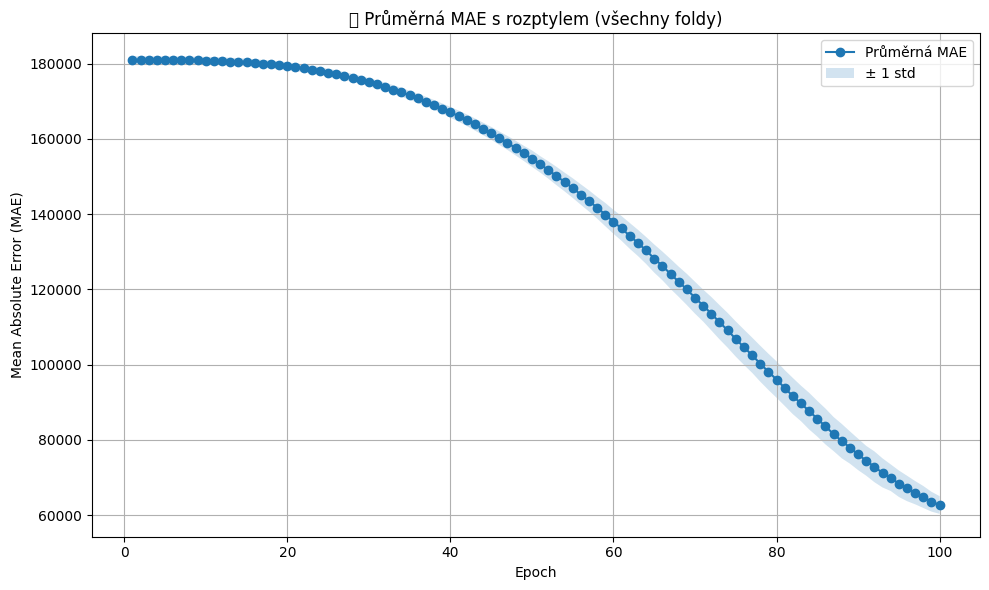

In [33]:
print("\n" + "=" * 50)
print("📊 Výsledky cross-validace:")
for i, score in enumerate(all_scores):
    print(f"Fold {i + 1}: MAE = {score:.2f}")

average = np.mean(all_scores)
print("-" * 50)
print(f"📈 Průměrná MAE přes {k} foldů: {average:.2f}")

epoch_maes = [
    [history.history["mae"][epoch] for history in all_histories]
    for epoch in range(num_epochs)
]
average_mae_history = [np.mean(epoch) for epoch in epoch_maes]
std_mae_history = [np.std(epoch) for epoch in epoch_maes]

plt.figure(figsize=(10, 6))
plt.plot(
    range(1, num_epochs + 1), average_mae_history, marker="o", label="Průměrná MAE"
)
plt.fill_between(
    range(1, num_epochs + 1),
    np.array(average_mae_history) - np.array(std_mae_history),
    np.array(average_mae_history) + np.array(std_mae_history),
    alpha=0.2,
    label="± 1 std",
)
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("📈 Průměrná MAE s rozptylem (všechny foldy)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [36]:
for i in range(10):
    predictions = model.predict(x_target.iloc[[i]], verbose=0)
    target_value = y_target.iloc[i]

    diff = int(target_value - predictions[0][0])
    pred = int(predictions[0][0])
    target = int(target_value)

    print(
        f"diff = {format(diff, ',').replace(',', ' ')} USD | "
        f"prediction = {format(pred, ',').replace(',', ' ')} USD | "
        f"target = {format(target, ',').replace(',', ' ')} USD"
    )

NameError: name 'x_target' is not defined